# Investigating Vix Levels And Returns

## Python Imports

In [1]:
# Standard Library
import os
import sys
import datetime
import random
import warnings

# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import dataframe_image as dfi

from matplotlib.ticker import FuncFormatter, FormatStrFormatter, MultipleLocator

# Data Sources
import yfinance as yf

# Statistical Analysis
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suppress warnings if needed
# warnings.filterwarnings("ignore")


## Set Base Directory

In [2]:
# Add the base directory to the system path
base_directory = "/home/jared/Cloud_Storage/Dropbox/Quant_Finance_Research"
sys.path.append(base_directory)

## Import Functions

In [3]:
# TBD

## Python Functions

In [4]:
# This function pulls data from Yahoo finance
def yf_data_updater(fund):
    
    # Download data from YF
    df_comp = yf.download(fund)

    # Drop the column level with the ticker symbol
    df_comp.columns = df_comp.columns.droplevel(1)

    # Reset index
    df_comp = df_comp.reset_index()

    # Remove the "Price" header from the index
    df_comp.columns.name = None

    # Reset date column
    df_comp['Date'] = df_comp['Date'].dt.tz_localize(None)

    # Set 'Date' column as index
    df_comp = df_comp.set_index('Date', drop=True)

    # Drop data from last day because it's not accrate until end of day
    df_comp = df_comp.drop(df_comp.index[-1])
    
    # Export data to excel
    file = fund + ".xlsx"
    df_comp.to_excel(file, sheet_name='data')

    print(f"The first and last date of data for {fund} is: ")
    print(df_comp[:1])
    print(df_comp[-1:])
    print(f"Data updater complete for {fund} data")
    
    return print(f"--------------------")

In [5]:
# Set number of decimal places in pandas
def dp(decimal_places):
    pd.set_option('display.float_format', lambda x: f'%.{decimal_places}f' % x)

In [6]:
def load_data(file):
    # Import CSV
    try:
        df = pd.read_csv(file)
    except:
        pass

    # Import excel
    try:
        df = pd.read_excel(file, sheet_name='data', engine='openpyxl')
    except:
        pass
        
    return df

In [7]:
# The `df_info` function returns some useful information about
# a dataframe, such as the columns, data types, and size.

def df_info(df):
    print('The columns, shape, and data types are:')
    print(df.info())
    print('The first 5 rows are:')
    display(df.head())
    print('The last 5 rows are:')
    display(df.tail())

## Import Data

### CBOE Volatility Index (VIX)

In [8]:
yf_data_updater('^VIX')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


The first and last date of data for ^VIX is: 
            Close   High    Low   Open  Volume
Date                                          
1990-01-02  17.24  17.24  17.24  17.24       0
                Close   High        Low   Open  Volume
Date                                                  
2025-03-20  19.799999  21.17  19.299999  19.52       0
Data updater complete for ^VIX data
--------------------


In [9]:
dp(2)

In [10]:
# VIX
vix = load_data('^VIX.xlsx')

# Set 'Date' column as datetime
vix['Date'] = pd.to_datetime(vix['Date'])

# Drop 'Volume'
vix.drop(columns = {'Volume'}, inplace = True)

# Set Date as index
vix.set_index('Date', inplace = True)

In [11]:
# Check to see if there are any NaN values
vix[vix['High'].isna()]

Empty DataFrame
Columns: [Close, High, Low, Open]
Index: []

In [12]:
# Forward fill to clean up missing data
vix['High'] = vix['High'].ffill()

In [13]:
df_info(vix)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8870 entries, 1990-01-02 to 2025-03-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8870 non-null   float64
 1   High    8870 non-null   float64
 2   Low     8870 non-null   float64
 3   Open    8870 non-null   float64
dtypes: float64(4)
memory usage: 346.5 KB
None
The first 5 rows are:


Close  High   Low  Open
Date                               
1990-01-02  17.24 17.24 17.24 17.24
1990-01-03  18.19 18.19 18.19 18.19
1990-01-04  19.22 19.22 19.22 19.22
1990-01-05  20.11 20.11 20.11 20.11
1990-01-08  20.26 20.26 20.26 20.26

The last 5 rows are:


Close  High   Low  Open
Date                               
2025-03-14  21.77 24.36 21.48 24.35
2025-03-17  20.51 22.95 20.32 22.89
2025-03-18  21.70 22.57 20.41 20.83
2025-03-19  19.90 22.10 19.42 21.84
2025-03-20  19.80 21.17 19.30 19.52

In [14]:
vix_stats = vix.describe()
vix_stats

Close    High     Low    Open
count 8870.00 8870.00 8870.00 8870.00
mean    19.46   20.37   18.80   19.56
std      7.82    8.36    7.39    7.90
min      9.14    9.31    8.56    9.01
25%     13.84   14.50   13.39   13.92
50%     17.62   18.32   17.03   17.66
75%     22.81   23.80   22.13   22.96
max     82.69   89.53   72.76   82.69

In [15]:
vix_stats.loc['mean + 1 std'] = {'Open': vix_stats.loc['mean']['Open'] + vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] + vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] + vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] + vix_stats.loc['std']['Close']}
vix_stats.loc['mean + 2 std'] = {'Open': vix_stats.loc['mean']['Open'] + 2 * vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] + 2 * vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] + 2 * vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] + 2 * vix_stats.loc['std']['Close']}
vix_stats.loc['mean - 1 std'] = {'Open': vix_stats.loc['mean']['Open'] - vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] - vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] - vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] - vix_stats.loc['std']['Close']}

In [16]:
vix_stats

Close    High     Low    Open
count        8870.00 8870.00 8870.00 8870.00
mean           19.46   20.37   18.80   19.56
std             7.82    8.36    7.39    7.90
min             9.14    9.31    8.56    9.01
25%            13.84   14.50   13.39   13.92
50%            17.62   18.32   17.03   17.66
75%            22.81   23.80   22.13   22.96
max            82.69   89.53   72.76   82.69
mean + 1 std   27.29   28.73   26.19   27.45
mean + 2 std   35.11   37.09   33.58   35.35
mean - 1 std   11.64   12.00   11.40   11.66

In [17]:
deciles = vix.quantile(np.arange(0, 1.1, 0.1))
display(deciles)

Close  High   Low  Open
0.00   9.14  9.31  8.56  9.01
0.10  12.11 12.62 11.72 12.13
0.20  13.24 13.86 12.84 13.29
0.30  14.57 15.27 14.06 14.64
0.40  16.07 16.74 15.53 16.11
0.50  17.62 18.32 17.03 17.66
0.60  19.53 20.36 18.98 19.65
0.70  21.59 22.60 20.96 21.74
0.80  24.28 25.29 23.45 24.37
0.90  28.67 29.95 27.74 28.82
1.00  82.69 89.53 72.76 82.69

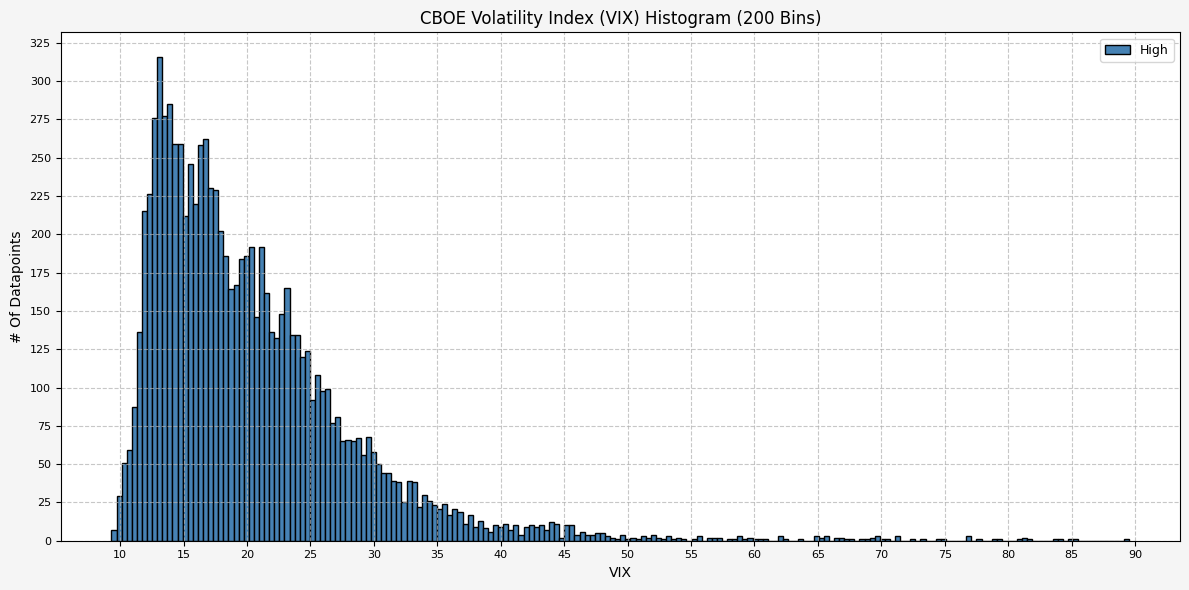

In [18]:
# Plotting
plt.figure(figsize=(12, 6), facecolor="#F5F5F5")

# Histogram
plt.hist([vix['High']], label=['High'], bins=200, edgecolor='black', color='steelblue')

# Set X axis
x_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel("VIX", fontsize=10)
plt.xticks(rotation=0, fontsize=8)

# Set Y axis
y_tick_spacing = 25  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel("# Of Datapoints", fontsize=10)
plt.yticks(fontsize=8)

# Set title, layout, grid, and legend
plt.title("CBOE Volatility Index (VIX) Histogram (200 Bins)", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=9)

# Save figure and display plot
plt.savefig("04_Histogram.png", dpi=300, bbox_inches="tight")
plt.show()

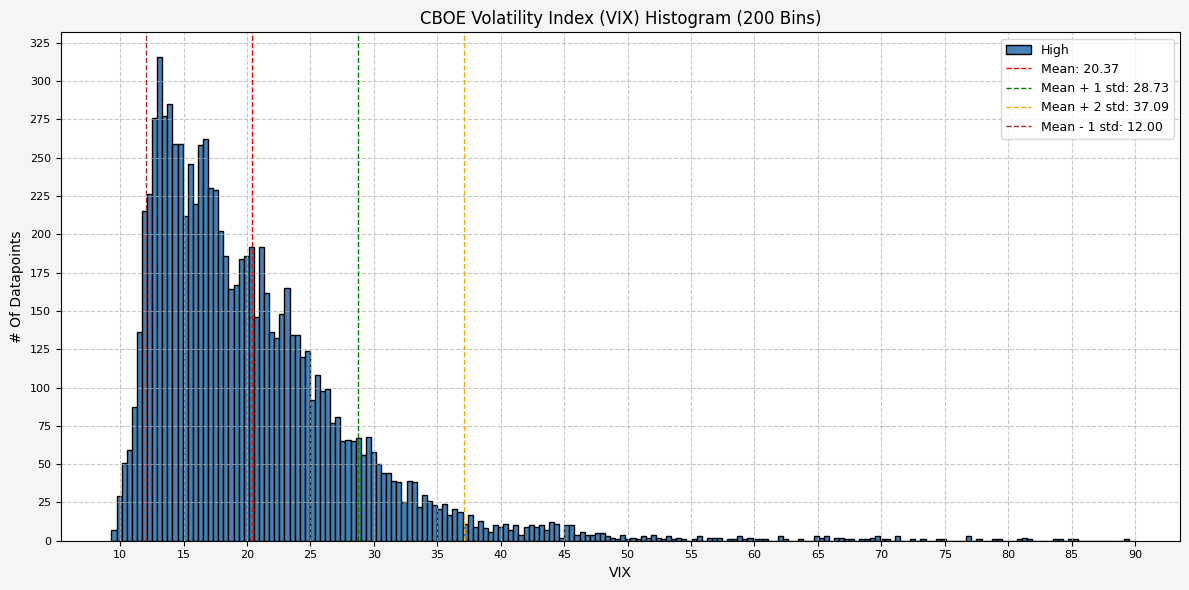

In [19]:
# Plotting
plt.figure(figsize=(12, 6), facecolor="#F5F5F5")

# Histogram
plt.hist([vix['High']], label=['High'], bins=200, edgecolor='black', color='steelblue')

# Plot a vertical line at the mean, mean + 1 std, and mean + 2 std
plt.axvline(vix_stats.loc['mean']['High'], color='red', linestyle='dashed', linewidth=1, label=f'Mean: {vix_stats.loc['mean']['High']:.2f}')
plt.axvline(vix_stats.loc['mean + 1 std']['High'], color='green', linestyle='dashed', linewidth=1, label=f'Mean + 1 std: {vix_stats.loc['mean + 1 std']['High']:.2f}')
plt.axvline(vix_stats.loc['mean + 2 std']['High'], color='orange', linestyle='dashed', linewidth=1, label=f'Mean + 2 std: {vix_stats.loc['mean + 2 std']['High']:.2f}')
plt.axvline(vix_stats.loc['mean - 1 std']['High'], color='brown', linestyle='dashed', linewidth=1, label=f'Mean - 1 std: {vix_stats.loc['mean - 1 std']['High']:.2f}')

# Set X axis
x_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel("VIX", fontsize=10)
plt.xticks(rotation=0, fontsize=8)

# Set Y axis
y_tick_spacing = 25  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel("# Of Datapoints", fontsize=10)
plt.yticks(fontsize=8)

# Set title, layout, grid, and legend
plt.title("CBOE Volatility Index (VIX) Histogram (200 Bins)", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=9)

# Save figure and display plot
plt.savefig("05_Histogram+Mean.png", dpi=300, bbox_inches="tight")
plt.show()

## Plots

### CBOE Volatility Index (VIX)

#### 1990 - 2009

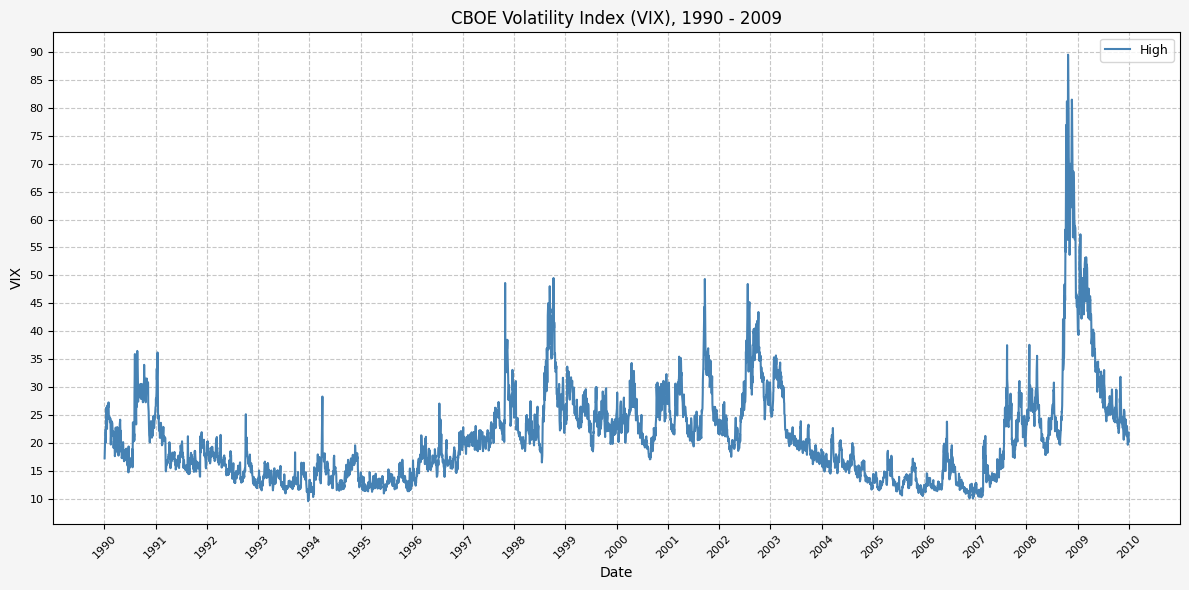

In [20]:
# Plotting
plt.figure(figsize=(12, 6), facecolor="#F5F5F5")

# Plot data
plt.plot(vix[vix.index <= '2009-12-31'].index, vix[vix.index <= '2009-12-31']['High'], label='High', linestyle='-', color='steelblue', linewidth=1.5)
# plt.plot(vix.index, vix['SMA_10'], label='10 Day SMA', linestyle='-', color='r', linewidth=1)
# plt.plot(vix.index, vix['SMA_20'], label='20 Day SMA', linestyle='-', color='orange', linewidth=1)
# plt.plot(vix.index, vix['SMA_50'], label='50 Day SMA', linestyle='-', color='g', linewidth=1)

# Set X axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Date", fontsize=10)
plt.xticks(rotation=45, fontsize=8)

# Set Y axis
y_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel("VIX", fontsize=10)
plt.yticks(fontsize=8)

# Set title, layout, grid, and legend
plt.title("CBOE Volatility Index (VIX), 1990 - 2009", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=9)

# Save figure and display plot
plt.savefig("06_Plot_1990-2009.png", dpi=300, bbox_inches="tight")
plt.show()

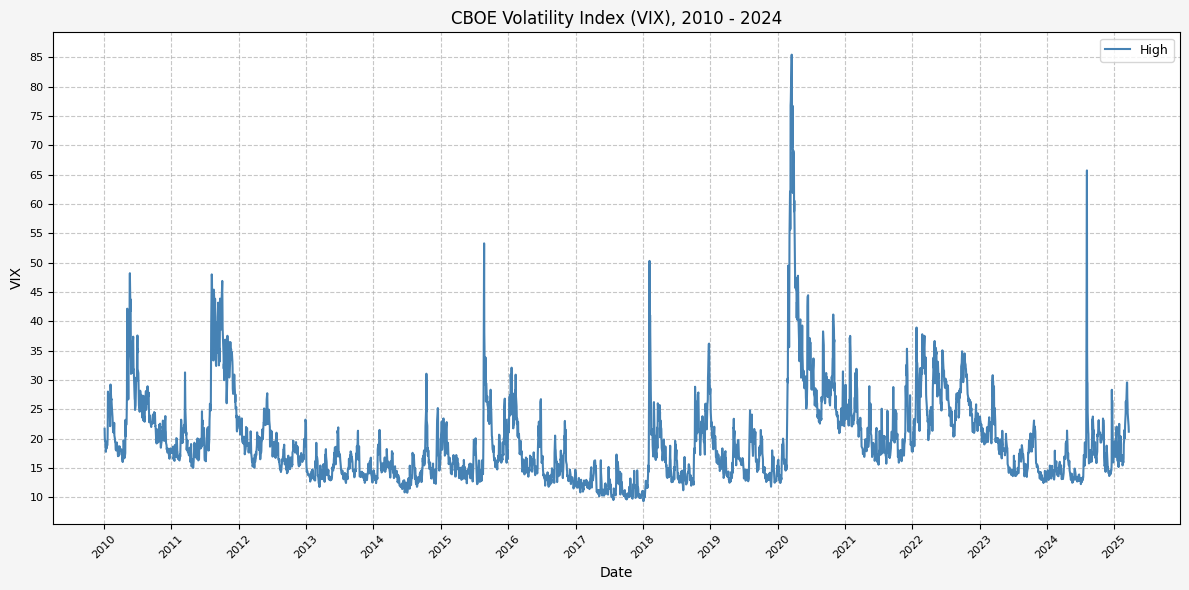

In [21]:
# Plotting
plt.figure(figsize=(12, 6), facecolor="#F5F5F5")

# Plot data
plt.plot(vix[vix.index > '2009-12-31'].index, vix[vix.index > '2009-12-31']['High'], label='High', linestyle='-', color='steelblue', linewidth=1.5)
# plt.plot(vix.index, vix['SMA_10'], label='10 Day SMA', linestyle='-', color='r', linewidth=1)
# plt.plot(vix.index, vix['SMA_20'], label='20 Day SMA', linestyle='-', color='orange', linewidth=1)
# plt.plot(vix.index, vix['SMA_50'], label='50 Day SMA', linestyle='-', color='g', linewidth=1)

# Set X axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Date", fontsize=10)
plt.xticks(rotation=45, fontsize=8)

# Set Y axis
y_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel("VIX", fontsize=10)
plt.yticks(fontsize=8)

# Set title, layout, grid, and legend
plt.title("CBOE Volatility Index (VIX), 2010 - 2024", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=9)

# Save figure and display plot
plt.savefig("07_Plot_2010-2024.png", dpi=300, bbox_inches="tight")
plt.show()

## Determining A Spike Level

In [22]:
# Define the spike multiplier for detecting significant spikes
spike_level = 1.25

# =========================
# Simple Moving Averages (SMA)
# =========================

# Calculate 10-period SMA of 'High'
vix['High_SMA_10'] = vix['High'].rolling(window=10).mean()

# Shift the 10-period SMA by 1 to compare with current 'High'
vix['High_SMA_10_Shift'] = vix['High_SMA_10'].shift(1)

# Calculate the spike level based on shifted SMA and spike multiplier
vix['Spike_Level_SMA'] = vix['High_SMA_10_Shift'] * spike_level

# Calculate 20-period SMA of 'High'
vix['High_SMA_20'] = vix['High'].rolling(window=20).mean()

# Determine if 'High' exceeds the spike level (indicates a spike)
vix['Spike_SMA'] = vix['High'] >= vix['Spike_Level_SMA']

# Calculate 50-period SMA of 'High' for trend analysis
vix['High_SMA_50'] = vix['High'].rolling(window=50).mean()

# =========================
# Exponential Moving Averages (EMA)
# =========================

# Calculate 10-period EMA of 'High'
vix['High_EMA_10'] = vix['High'].ewm(span=10, adjust=False).mean()

# Shift the 10-period EMA by 1 to compare with current 'High'
vix['High_EMA_10_Shift'] = vix['High_EMA_10'].shift(1)

# Calculate the spike level based on shifted EMA and spike multiplier
vix['Spike_Level_EMA'] = vix['High_EMA_10_Shift'] * spike_level

# Calculate 20-period EMA of 'High'
vix['High_EMA_20'] = vix['High'].ewm(span=20, adjust=False).mean()

# Determine if 'High' exceeds the spike level (indicates a spike)
vix['Spike_EMA'] = vix['High'] >= vix['Spike_Level_EMA']

# Calculate 50-period EMA of 'High' for trend analysis
vix['High_EMA_50'] = vix['High'].ewm(span=50, adjust=False).mean()


In [23]:
vix.head()

Close  High   Low  Open  High_SMA_10  High_SMA_10_Shift  \
Date                                                                  
1990-01-02  17.24 17.24 17.24 17.24          NaN                NaN   
1990-01-03  18.19 18.19 18.19 18.19          NaN                NaN   
1990-01-04  19.22 19.22 19.22 19.22          NaN                NaN   
1990-01-05  20.11 20.11 20.11 20.11          NaN                NaN   
1990-01-08  20.26 20.26 20.26 20.26          NaN                NaN   

            Spike_Level_SMA  High_SMA_20  Spike_SMA  High_SMA_50  High_EMA_10  \
Date                                                                            
1990-01-02              NaN          NaN      False          NaN        17.24   
1990-01-03              NaN          NaN      False          NaN        17.41   
1990-01-04              NaN          NaN      False          NaN        17.74   
1990-01-05              NaN          NaN      False          NaN        18.17   
1990-01-08              NaN          NaN      False          NaN        18.55   

            High_EMA_10_Shift  Spike_Level_EMA  High_EMA_20  Spike_EMA  \
Date                                                                     
1990-01-02                NaN              NaN        17.24      False   
1990-01-03              17.24            21.55        17.33      False   
1990-01-04              17.41            21.77        17.51      False   
1990-01-05              17.74            22.18        17.76      False   
1990-01-08              18.17            22.71        18.00      False   

            High_EMA_50  
Date                     
1990-01-02        17.24  
1990-01-03        17.28  
1990-01-04        17.35  
1990-01-05        17.46  
1990-01-08        17.57

In [24]:
vix.tail()

Close  High   Low  Open  High_SMA_10  High_SMA_10_Shift  \
Date                                                                  
2025-03-14  21.77 24.36 21.48 24.35        26.45              26.25   
2025-03-17  20.51 22.95 20.32 22.89        26.31              26.45   
2025-03-18  21.70 22.57 20.41 20.83        25.94              26.31   
2025-03-19  19.90 22.10 19.42 21.84        25.66              25.94   
2025-03-20  19.80 21.17 19.30 19.52        25.19              25.66   

            Spike_Level_SMA  High_SMA_20  Spike_SMA  High_SMA_50  High_EMA_10  \
Date                                                                            
2025-03-14            32.82        22.66      False        19.78        25.58   
2025-03-17            33.06        23.04      False        19.88        25.10   
2025-03-18            32.89        23.36      False        19.94        24.64   
2025-03-19            32.42        23.67      False        20.03        24.18   
2025-03-20            32.08        23.90      False        20.11        23.63   

            High_EMA_10_Shift  Spike_Level_EMA  High_EMA_20  Spike_EMA  \
Date                                                                     
2025-03-14              25.85            32.31        23.67      False   
2025-03-17              25.58            31.97        23.60      False   
2025-03-18              25.10            31.37        23.50      False   
2025-03-19              24.64            30.80        23.37      False   
2025-03-20              24.18            30.22        23.16      False   

            High_EMA_50  
Date                     
2025-03-14        20.92  
2025-03-17        21.00  
2025-03-18        21.06  
2025-03-19        21.11  
2025-03-20        21.11

In [25]:
vix[vix['High'] >= 50]

Close  High   Low  Open  High_SMA_10  High_SMA_10_Shift  \
Date                                                                  
2008-10-06  52.05 58.24 45.12 45.12        42.92              40.52   
2008-10-07  53.68 54.19 47.03 52.05        44.73              42.92   
2008-10-08  57.53 59.06 51.90 53.68        46.97              44.73   
2008-10-09  63.92 64.92 52.54 57.57        49.94              46.97   
2008-10-10  69.95 76.94 65.63 65.85        53.99              49.94   
...           ...   ...   ...   ...          ...                ...   
2020-03-31  53.54 58.75 50.88 56.69        70.93              73.54   
2020-04-01  57.06 60.59 52.76 57.38        68.44              70.93   
2020-04-02  50.91 57.24 50.45 54.46        65.74              68.44   
2020-04-03  46.80 52.29 46.74 51.11        64.02              65.74   
2024-08-05  38.57 65.73 23.39 23.39        23.84              18.95   

            Spike_Level_SMA  High_SMA_20  Spike_SMA  High_SMA_50  High_EMA_10  \
Date                                                                            
2008-10-06            50.65        37.24       True        28.17        44.33   
2008-10-07            53.65        38.66       True        28.76        46.12   
2008-10-08            55.91        40.34       True        29.46        48.47   
2008-10-09            58.71        42.27       True        30.31        51.46   
2008-10-10            62.42        44.79       True        31.39        56.10   
...                     ...          ...        ...          ...          ...   
2020-03-31            91.93        66.93      False        39.38        67.38   
2020-04-01            88.67        68.18      False        40.33        66.15   
2020-04-02            85.56        68.90      False        41.21        64.53   
2020-04-03            82.18        68.79      False        41.98        62.30   
2024-08-05            23.69        19.11       True        15.66        28.04   

            High_EMA_10_Shift  Spike_Level_EMA  High_EMA_20  Spike_EMA  \
Date                                                                     
2008-10-06              41.24            51.55        38.82       True   
2008-10-07              44.33            55.41        40.29      False   
2008-10-08              46.12            57.65        42.07       True   
2008-10-09              48.47            60.59        44.25       True   
2008-10-10              51.46            64.33        47.36       True   
...                       ...              ...          ...        ...   
2020-03-31              69.30            86.62        63.00      False   
2020-04-01              67.38            84.23        62.77      False   
2020-04-02              66.15            82.68        62.24      False   
2020-04-03              64.53            80.66        61.30      False   
2024-08-05              19.66            24.58        22.15       True   

            High_EMA_50  
Date                     
2008-10-06        31.65  
2008-10-07        32.53  
2008-10-08        33.57  
2008-10-09        34.80  
2008-10-10        36.46  
...                 ...  
2020-03-31        46.75  
2020-04-01        47.29  
2020-04-02        47.68  
2020-04-03        47.86  
2024-08-05        17.62  

[93 rows x 16 columns]

### Spike Totals By Year

In [26]:
# Ensure the index is a DatetimeIndex
vix.index = pd.to_datetime(vix.index)

# Create a new column for the year extracted from the date index
vix['Year'] = vix.index.year

# Group by year and the "Spike_SMA" and "Spike_EMA" columns, then count occurrences
spike_count_SMA = vix.groupby(['Year', 'Spike_SMA']).size().unstack(fill_value=0)

spike_count_SMA

Spike_SMA  False  True 
Year                   
1990         248      5
1991         249      4
1992         250      4
1993         251      2
1994         243      9
1995         252      0
1996         248      6
1997         247      6
1998         243      9
1999         250      2
2000         248      4
2001         240      8
2002         248      4
2003         251      1
2004         250      2
2005         250      2
2006         242      9
2007         239     12
2008         238     15
2009         249      3
2010         239     13
2011         240     12
2012         248      2
2013         249      3
2014         235     17
2015         240     12
2016         234     18
2017         244      7
2018         228     23
2019         241     11
2020         224     29
2021         235     17
2022         239     12
2023         246      4
2024         237     15
2025          48      5

In [27]:
# Ensure the index is a DatetimeIndex
vix.index = pd.to_datetime(vix.index)

# Create a new column for the year extracted from the date index
vix['Year'] = vix.index.year

# Group by year and the "Spike_SMA" and "Spike_EMA" columns, then count occurrences
spike_count_EMA = vix.groupby(['Year', 'Spike_EMA']).size().unstack(fill_value=0)

spike_count_EMA

Spike_EMA  False  True 
Year                   
1990         247      6
1991         251      2
1992         253      1
1993         251      2
1994         247      5
1995         252      0
1996         252      2
1997         250      3
1998         246      6
1999         250      2
2000         250      2
2001         241      7
2002         250      2
2003         251      1
2004         251      1
2005         250      2
2006         248      3
2007         242      9
2008         240     13
2009         251      1
2010         243      9
2011         242     10
2012         250      0
2013         250      2
2014         236     16
2015         243      9
2016         238     14
2017         244      7
2018         230     21
2019         242     10
2020         228     25
2021         239     13
2022         244      7
2023         248      2
2024         244      8
2025          50      3

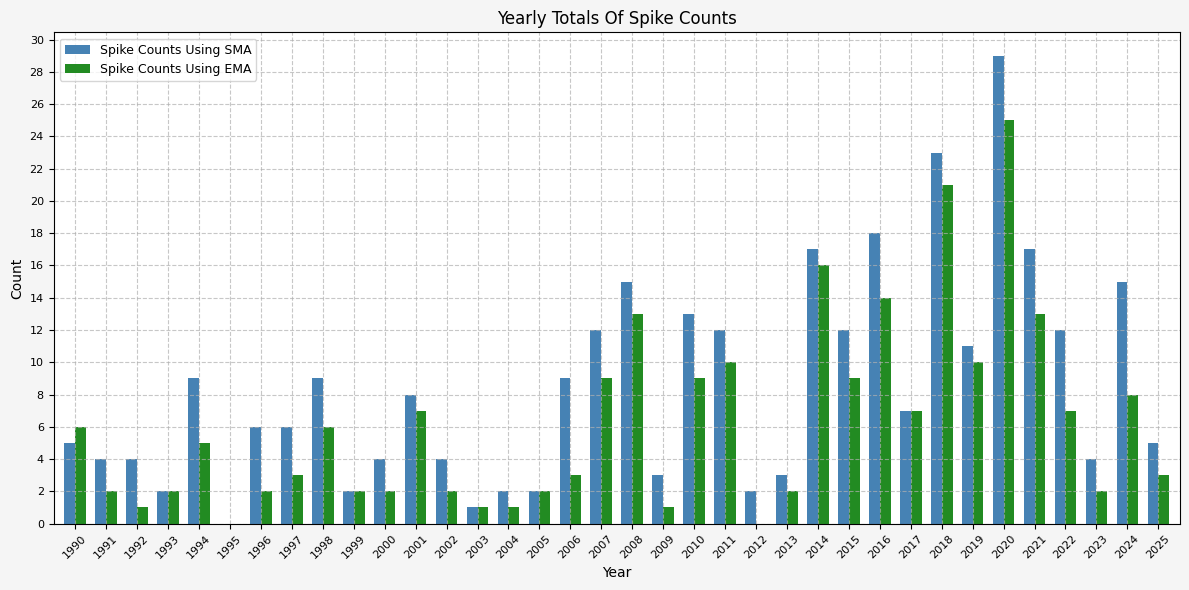

In [28]:
# Plotting
plt.figure(figsize=(12, 6), facecolor="#F5F5F5")

# Bar positions
x = np.arange(len(spike_count_SMA[True].index))
width = 0.35

# Plot SMA bars
plt.bar(x - width / 2, spike_count_SMA[True].values, width, color="steelblue", label="Spike Counts Using SMA")

# Plot EMA bars
plt.bar(x + width / 2, spike_count_EMA[True].values, width, color="forestgreen", label="Spike Counts Using EMA")

# Set X axis
# x_tick_spacing = 5  # Specify the interval for y-axis ticks
# plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel("Year", fontsize=10)
plt.xticks(x, spike_count_SMA[True].index, rotation=45, fontsize=8)
plt.xlim(x[0] - 2 * width, x[-1] + 2 * width)

# # Set Y axis
y_tick_spacing = 2  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel("Count", fontsize=10)
plt.yticks(fontsize=8)

# Set title, layout, grid, and legend
plt.title("Yearly Totals Of Spike Counts", fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=9)

# Save figure and display plot
plt.savefig("08_Spike_Counts.png", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
def vix_plot(start_year, end_year):
    # Start and end dates
    start_date = start_year + '-01-01'
    end_date = end_year + '-12-31'

    # Create temporary dataframe for the specified date range
    vix_temp = vix[(vix.index >= start_date) & (vix.index <= end_date)]

    # Plotting
    plt.figure(figsize=(12, 6), facecolor="#F5F5F5")

    # Plot data
    plt.plot(vix_temp.index, vix_temp['High'], label='High', linestyle='-', color='steelblue', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['Low'], label='Low', linestyle='-', color='brown', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['High_SMA_10'], label='10 Day High SMA', linestyle='-', color='red', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['High_SMA_20'], label='20 Day High SMA', linestyle='-', color='orange', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['High_SMA_50'], label='50 Day High SMA', linestyle='-', color='green', linewidth=1)
    plt.scatter(vix_temp[vix_temp['Spike_SMA'] == True].index, vix_temp[vix_temp['Spike_SMA'] == True]['High'], label='Spike (High > 1.25 * 10 Day High SMA)', linestyle='-', color='black', s=20)

    # Set X axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xlabel("Date", fontsize=10)
    plt.xticks(rotation=45, fontsize=8)

    # Set Y axis
    y_tick_spacing = 5  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.ylabel("VIX", fontsize=10)
    plt.yticks(fontsize=8)

    # Set title, layout, grid, and legend
    plt.title(f"CBOE Volatility Index (VIX), {start_year} - {end_year}", fontsize=12)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=9)

    # Save figure and display plot
    plt.savefig(f"09_VIX_SMA_Spike_{start_year}_{end_year}.png", dpi=300, bbox_inches="tight")
    plt.show()

#### 1990

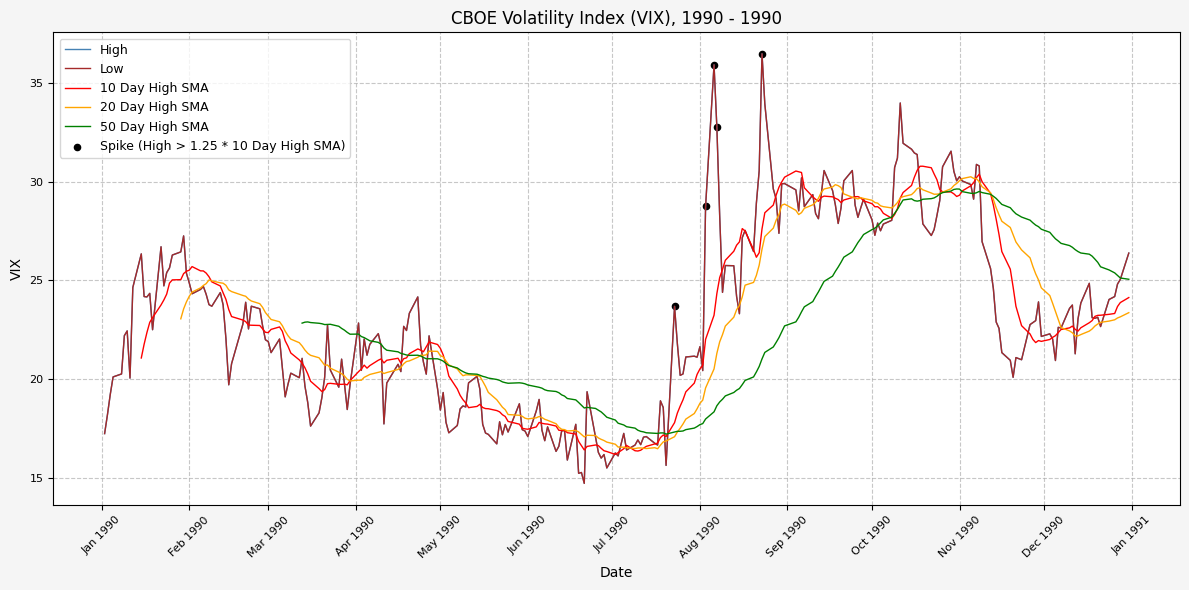

In [30]:
vix_plot('1990', '1990')

#### 1999

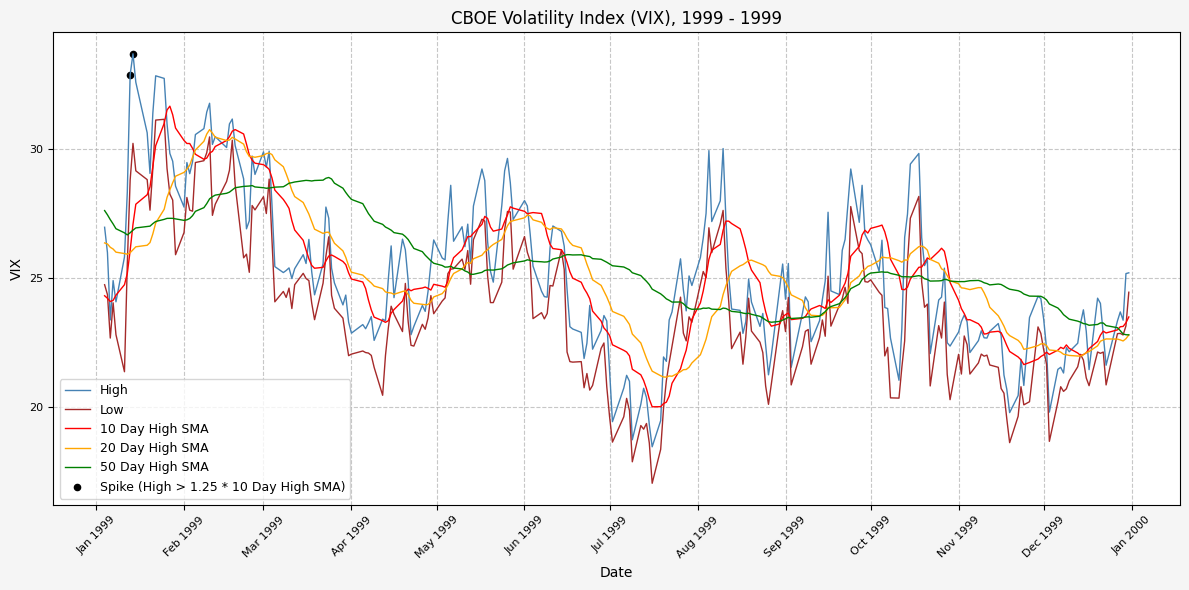

In [31]:
vix_plot('1999', '1999')

#### 2011

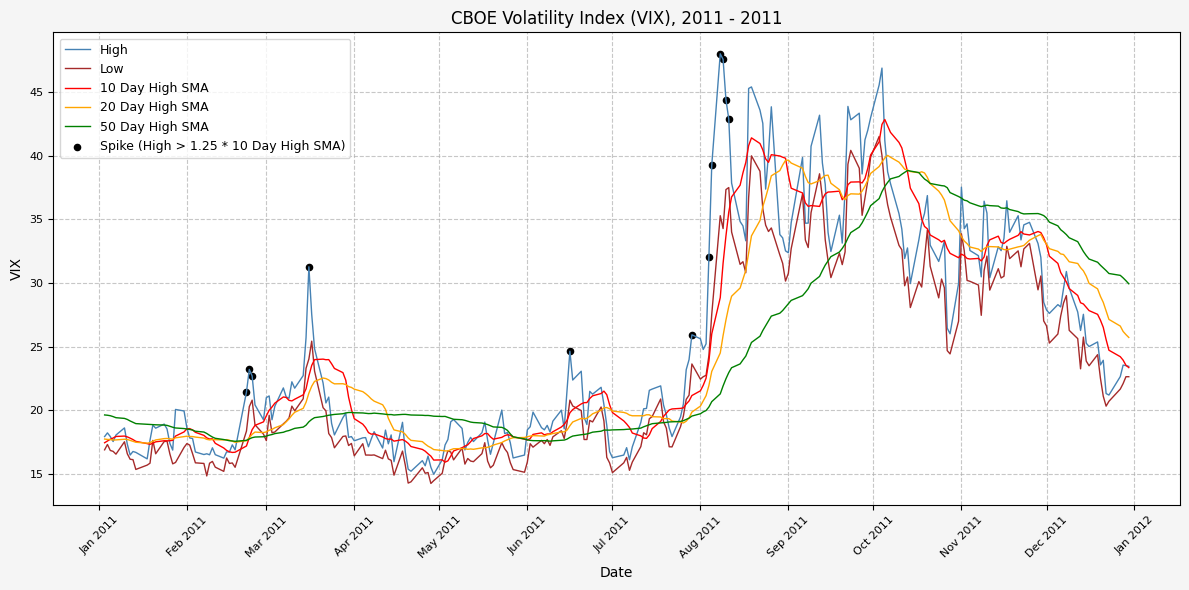

In [32]:
vix_plot('2011', '2011')

#### 2018

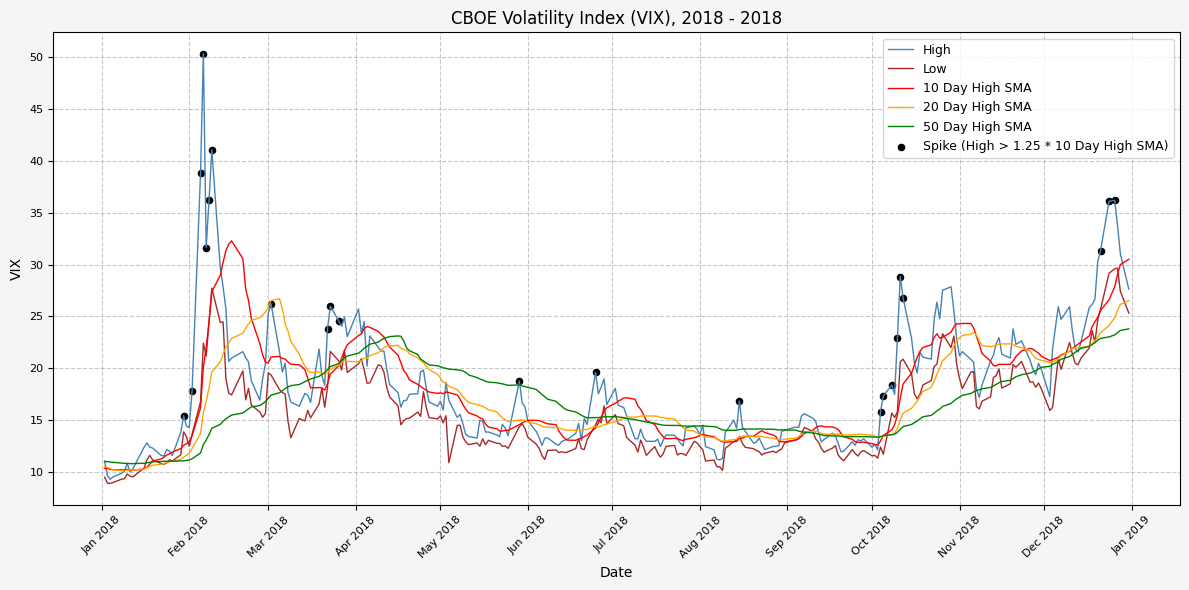

In [33]:
vix_plot('2018', '2018')

#### 2019

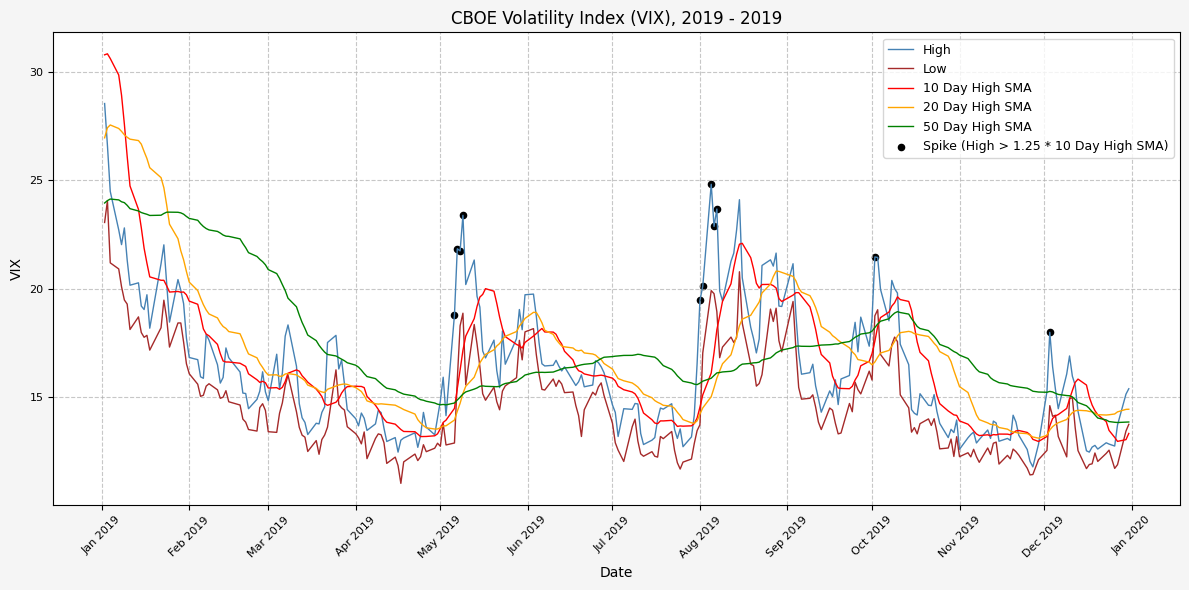

In [34]:
vix_plot('2019', '2019')

#### 2020

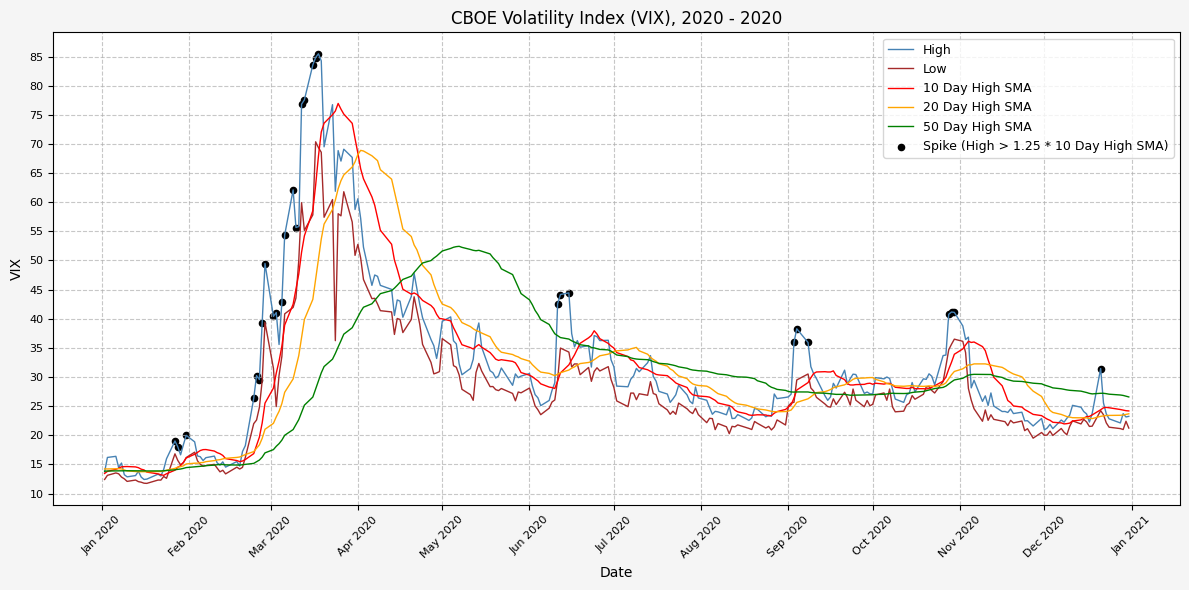

In [35]:
vix_plot('2020', '2020')

#### 2021

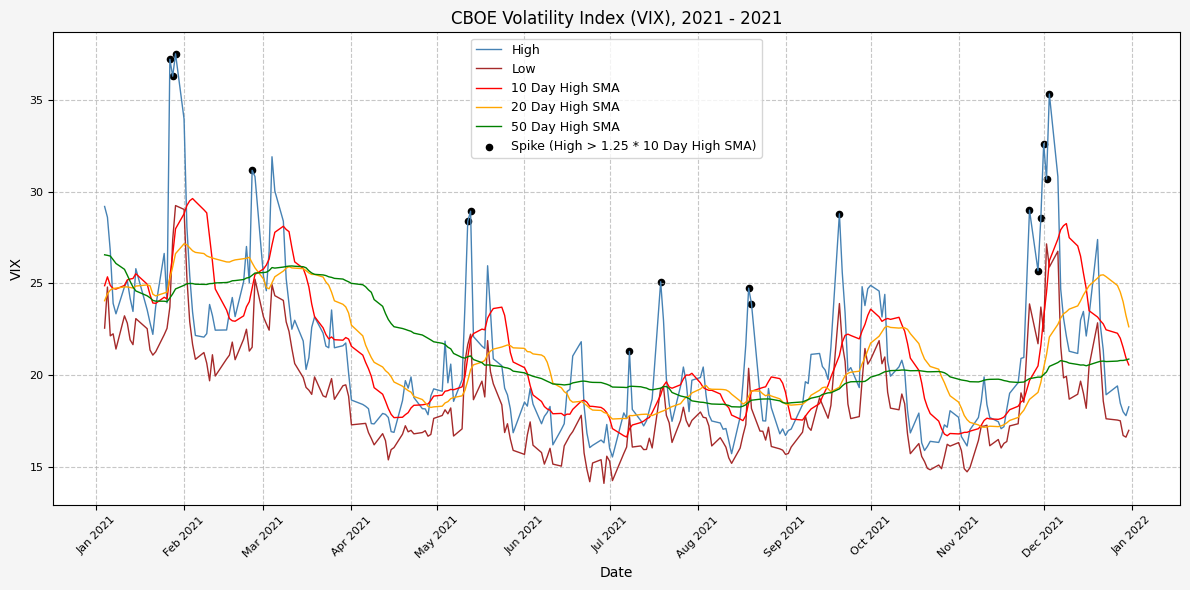

In [36]:
vix_plot('2021', '2021')

#### 2022

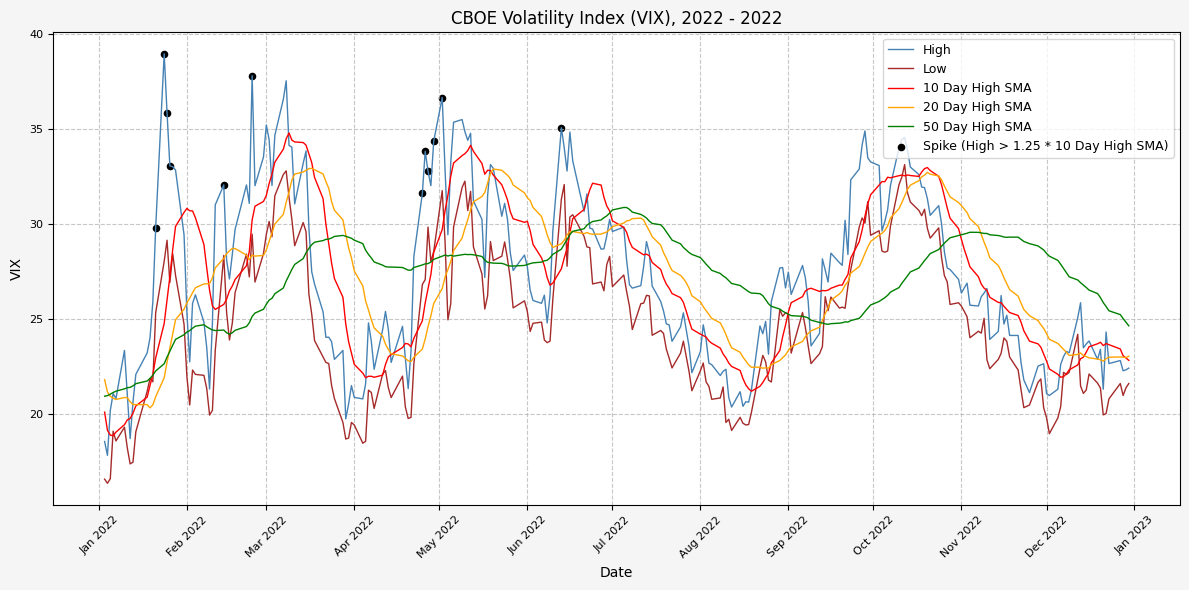

In [37]:
vix_plot('2022', '2022')

#### 2023

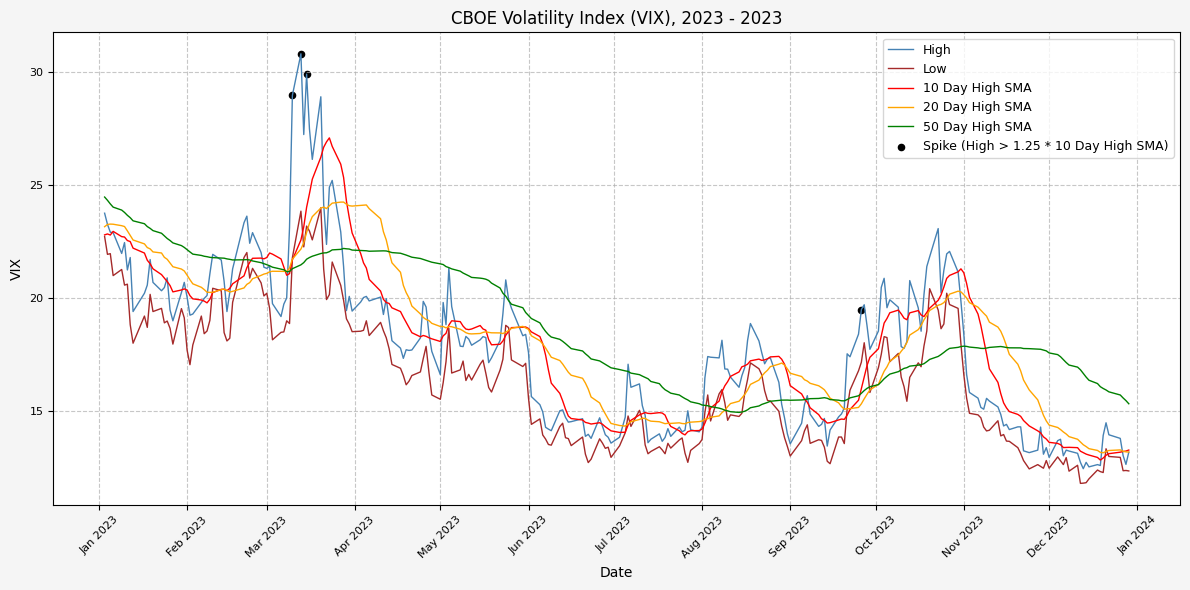

In [38]:
vix_plot('2023', '2023')

#### 2024

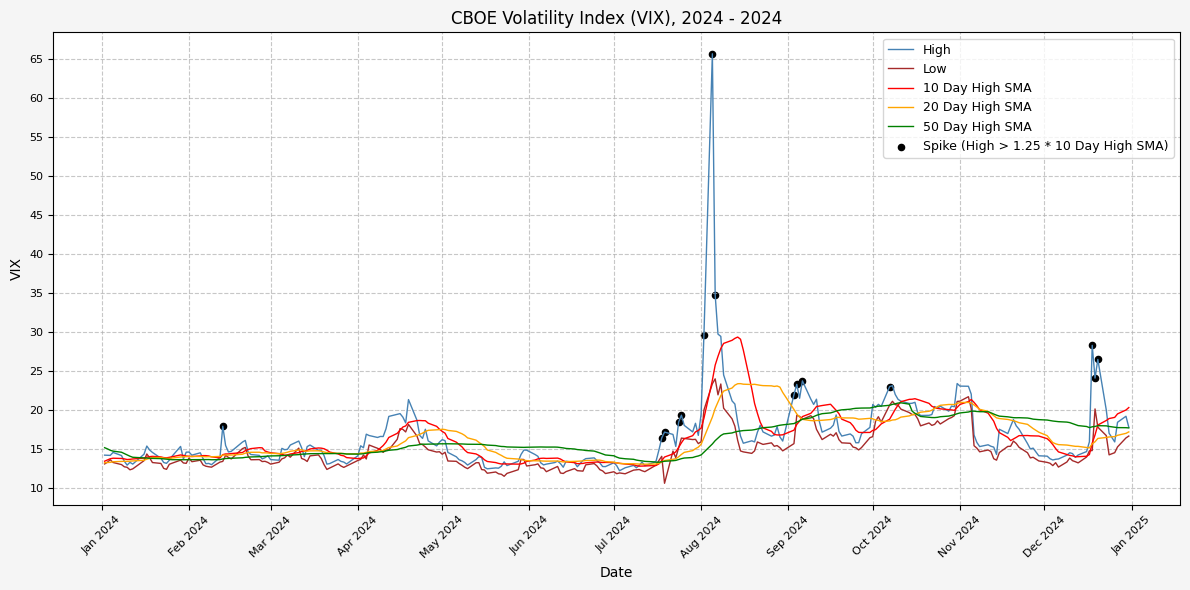

In [39]:
vix_plot('2024', '2024')

#### 1990 - 1994

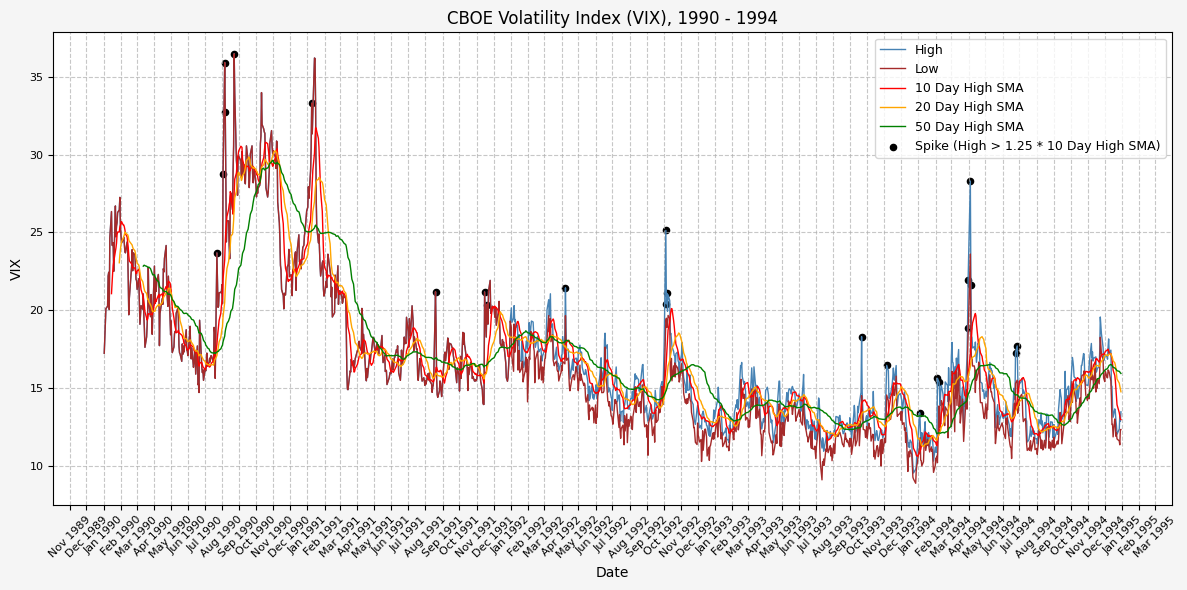

In [40]:
vix_plot('1990', '1994')

#### 1995 - 1999

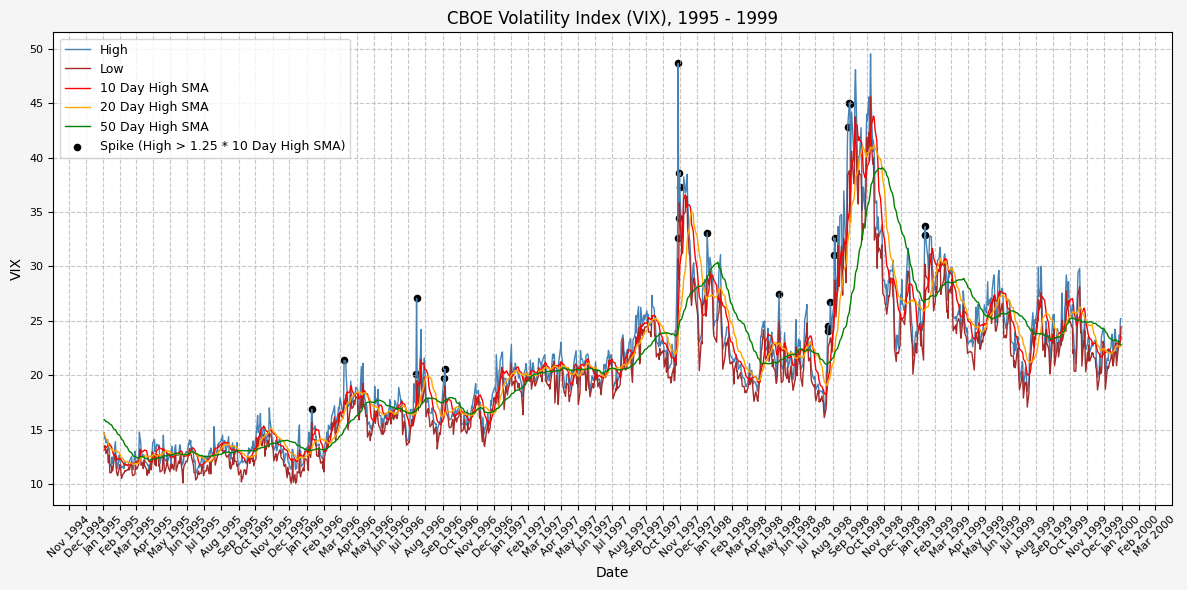

In [41]:
vix_plot('1995', '1999')

#### 2000 - 2004

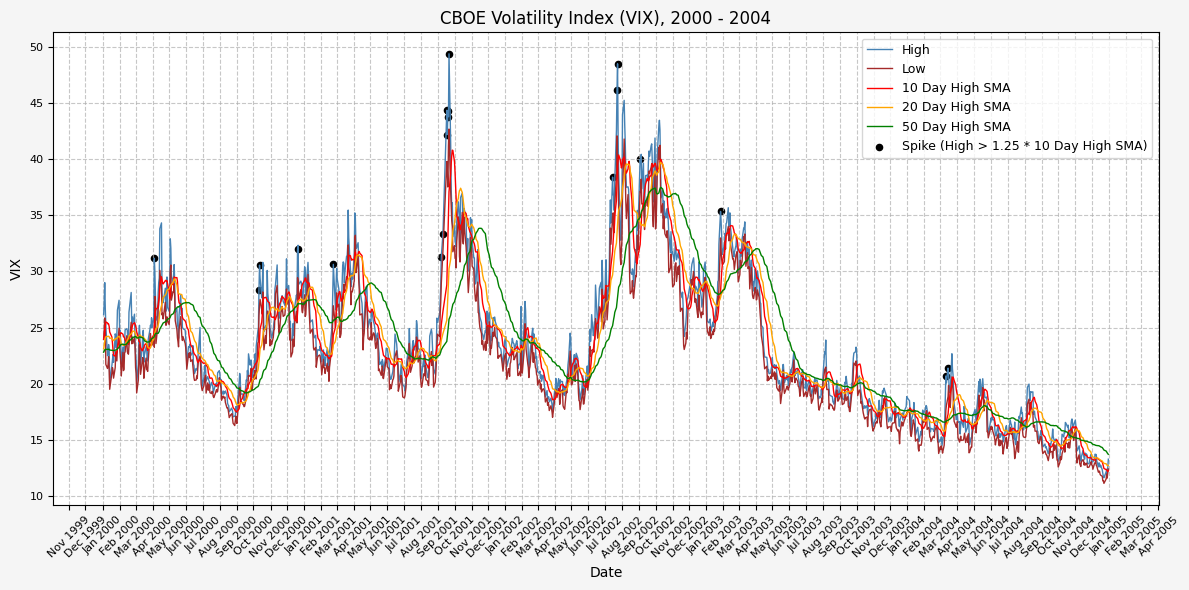

In [42]:
vix_plot('2000', '2004')

#### 2005 - 2009

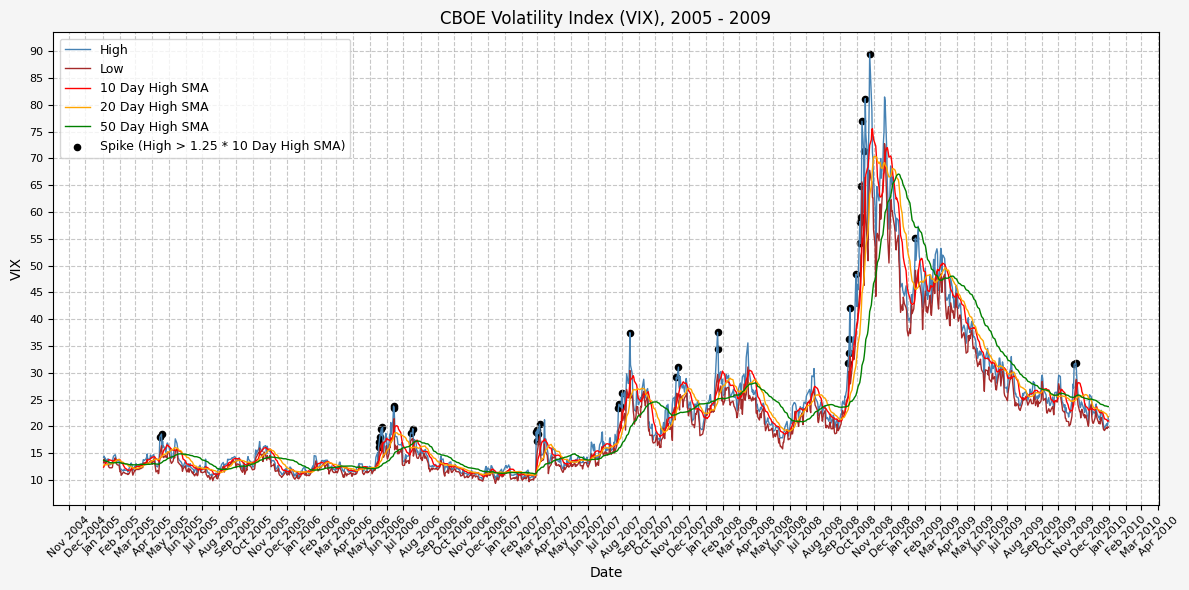

In [43]:
vix_plot('2005', '2009')

#### 2010 - 2014

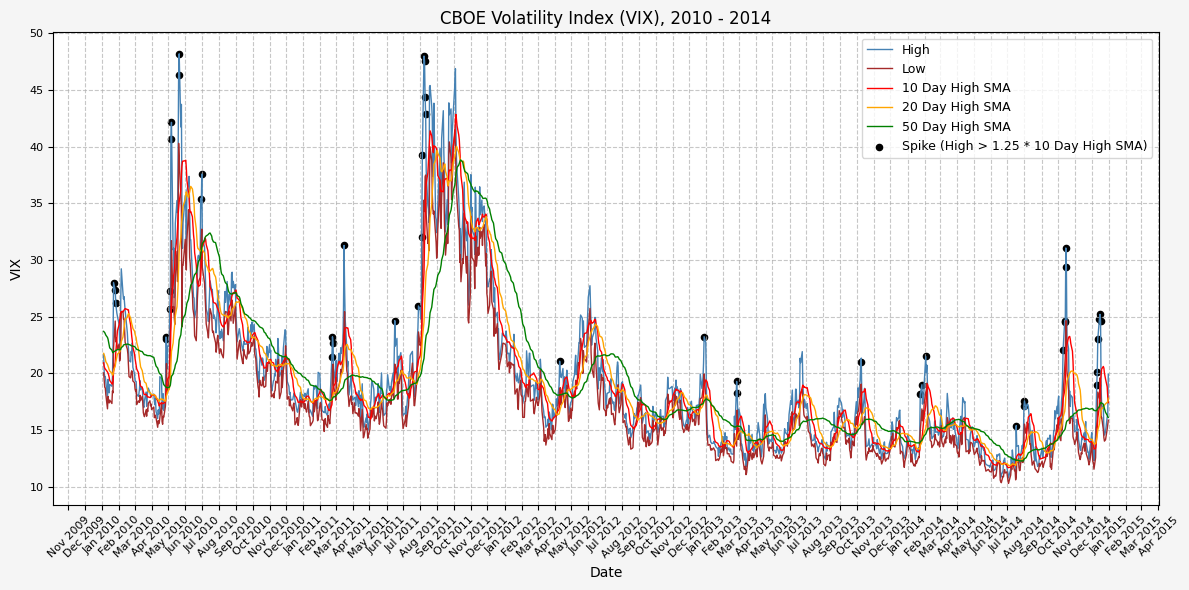

In [44]:
vix_plot('2010', '2014')

#### 2015 - 2019

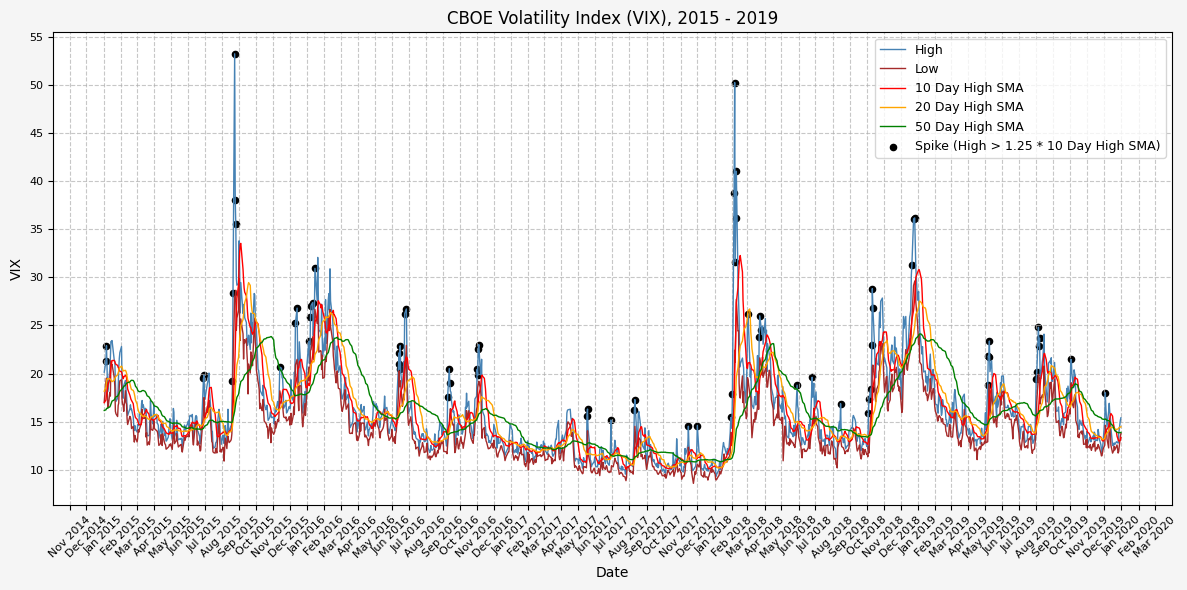

In [45]:
vix_plot('2015', '2019')

#### 2020 - 2024

#### 2025 - 2025

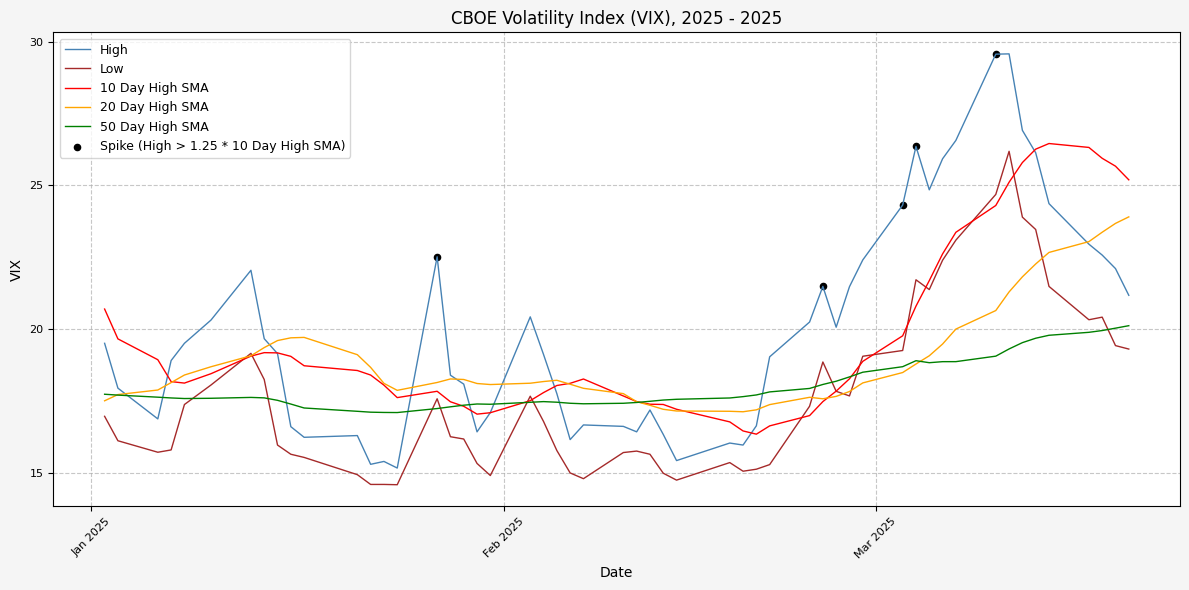

In [47]:
vix_plot('2025', '2025')

In [48]:
vix.tail(10)

Close  High   Low  Open  High_SMA_10  High_SMA_10_Shift  \
Date                                                                  
2025-03-07  23.37 26.56 23.09 24.85        23.36              22.61   
2025-03-10  27.86 29.56 24.68 24.70        24.29              23.36   
2025-03-11  26.92 29.57 26.18 27.94        25.10              24.29   
2025-03-12  24.23 26.91 23.89 26.88        25.79              25.10   
2025-03-13  24.66 26.13 23.46 24.92        26.25              25.79   
2025-03-14  21.77 24.36 21.48 24.35        26.45              26.25   
2025-03-17  20.51 22.95 20.32 22.89        26.31              26.45   
2025-03-18  21.70 22.57 20.41 20.83        25.94              26.31   
2025-03-19  19.90 22.10 19.42 21.84        25.66              25.94   
2025-03-20  19.80 21.17 19.30 19.52        25.19              25.66   

            Spike_Level_SMA  High_SMA_20  Spike_SMA  High_SMA_50  High_EMA_10  \
Date                                                                            
2025-03-07            28.26        19.99      False        18.86        23.54   
2025-03-10            29.20        20.64       True        19.05        24.64   
2025-03-11            30.37        21.29      False        19.30        25.54   
2025-03-12            31.38        21.81      False        19.52        25.79   
2025-03-13            32.24        22.26      False        19.68        25.85   
2025-03-14            32.82        22.66      False        19.78        25.58   
2025-03-17            33.06        23.04      False        19.88        25.10   
2025-03-18            32.89        23.36      False        19.94        24.64   
2025-03-19            32.42        23.67      False        20.03        24.18   
2025-03-20            32.08        23.90      False        20.11        23.63   

            High_EMA_10_Shift  Spike_Level_EMA  High_EMA_20  Spike_EMA  \
Date                                                                     
2025-03-07              22.87            28.59        21.48      False   
2025-03-10              23.54            29.43        22.25       True   
2025-03-11              24.64            30.80        22.95      False   
2025-03-12              25.54            31.92        23.33      False   
2025-03-13              25.79            32.23        23.59      False   
2025-03-14              25.85            32.31        23.67      False   
2025-03-17              25.58            31.97        23.60      False   
2025-03-18              25.10            31.37        23.50      False   
2025-03-19              24.64            30.80        23.37      False   
2025-03-20              24.18            30.22        23.16      False   

            High_EMA_50  Year  
Date                           
2025-03-07        19.53  2025  
2025-03-10        19.93  2025  
2025-03-11        20.31  2025  
2025-03-12        20.56  2025  
2025-03-13        20.78  2025  
2025-03-14        20.92  2025  
2025-03-17        21.00  2025  
2025-03-18        21.06  2025  
2025-03-19        21.11  2025  
2025-03-20        21.11  2025